In [1]:
import sys, os
modulepath = os.path.abspath("ssh_1d_cpp/build/bin-module/")
sys.path.insert(0,modulepath)

In [2]:
import ssh_1d
import numpy as np

N = 10
Ns = 2*N+1
psi0 = 0.01
t0=0.
t_end=1200
dt = 0.01

gamA = 0.16
gamA = 0.48
gamB = gamA
gA = 0.44 + gamA
gA = 0.06 + gamA
gB = 0
t1=1
t2=0.7

time_series = ssh_1d.time_series(N, psi0, gA, gB, gamA, gamB, t_end, dt, t1, t2)


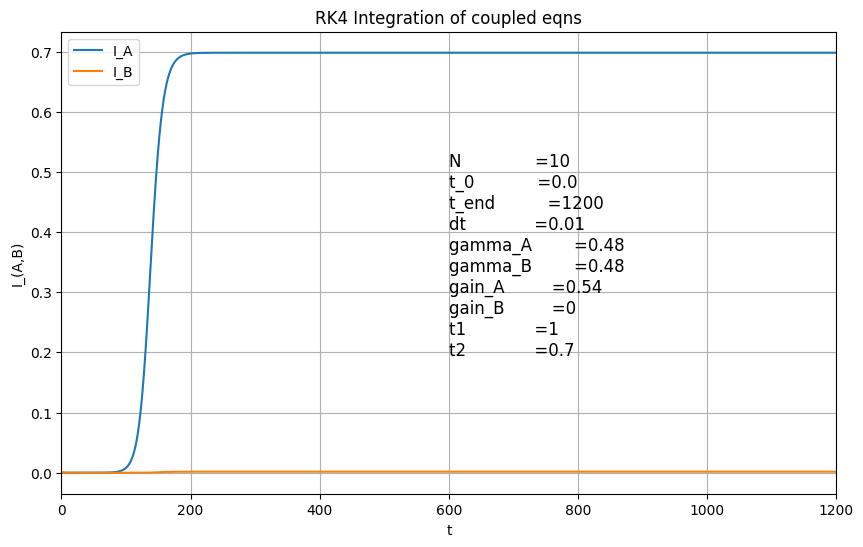

In [3]:
import matplotlib.pyplot as plt

t_values = time_series[:,0].real
psi_values = time_series[:,1:]

IA = np.sum(np.abs(psi_values[:,0::2])**2, axis=1)
IB = np.sum(np.abs(psi_values[:,1::2])**2, axis=1)

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(t_values, IA, label='I_A')
ax.plot(t_values, IB, label='I_B')

ax.set_xlabel('t')
ax.set_ylabel('I_(A,B)')
ax.legend()
ax.set_title('RK4 Integration of coupled eqns')
# ax.set_xlim((400,600))
# ax.set_ylim((30.2499,30.2501))
ax.set_xmargin(0)
ax.grid(True)
params = {'N':N, 't_0':t0, 't_end': t_end, 'dt':dt, 'gamma_A':gamA, 'gamma_B':gamB, 'gain_A': gA, 'gain_B':gB, 't1':t1, 't2':t2}
paramtext = "\n".join([ f"{key:<15}={value:<6}" for key, value in params.items()])
ax.text(x=.5, y=.3,s=paramtext, color='black', transform=ax.transAxes, size=12)

plt.show()

In [4]:
from numpy import fft
time_section_filter = (800<t_values)*(t_values<900)
psi_fft = fft.fft(psi_values[time_section_filter,:], axis=0)

8.89551112099894e-26

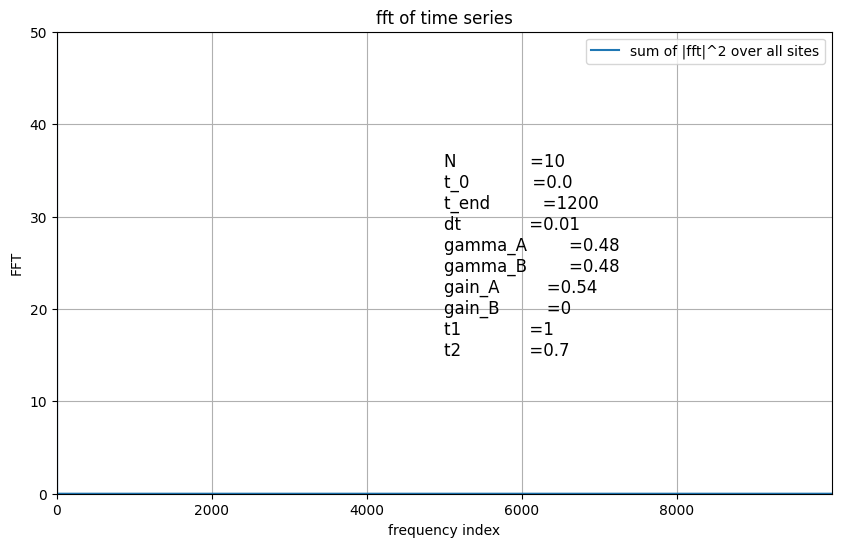

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

psi_fft_all_sites = np.sum(np.abs(psi_fft)**2, axis=1)

ax.plot(psi_fft_all_sites, label='sum of |fft|^2 over all sites')

ax.set_xlabel('frequency index')
ax.set_ylabel('FFT')
ax.legend()
ax.set_title('fft of time series')
ax.set_ylim((0,50))
ax.set_xmargin(0)
ax.grid(True)
params = {'N':N, 't_0':t0, 't_end': t_end, 'dt':dt, 'gamma_A':gamA, 'gamma_B':gamB, 'gain_A': gA, 'gain_B':gB, 't1':t1, 't2':t2}
paramtext = "\n".join([ f"{key:<15}={value:<6}" for key, value in params.items()])
ax.text(x=.5, y=.3,s=paramtext, color='black', transform=ax.transAxes, size=12)
np.max(psi_fft_all_sites[1:])

In [6]:
#phase diagram as in fig 1b in paper
import ssh_1d
from numpy import fft
import numpy as np
import concurrent.futures

numx = 50
numy = 50

x_ = np.linspace(0,.5,numx) # gamma_AB
y_ = np.linspace(0,0.5,numy) # g_A - gamma_AB

def is_oscillating_worker(x,y):
    gamA = x
    time_series = ssh_1d.time_series(N=10, psi0=0.01, satGainA=y+gamA, satGainB=0.,
                                     gammaA=gamA, gammaB=gamA, time_end=1200, time_delta=0.01,
                                     t1=1., t2=0.7)
    t_values = time_series[:,0].real
    psi_values = time_series[:,1:]
    time_section_filter = (850<t_values)*(t_values<900)
    psi_fft = fft.fft(psi_values[time_section_filter,:], axis=0)
    psi_fft_all_sites = np.sum(np.abs(psi_fft)**2, axis=1)
    return np.max(psi_fft_all_sites[1:])>5

xy_pairs = np.array([(x,y) for y in y_ for x in x_])


phase_diagram = []

with concurrent.futures.ThreadPoolExecutor(max_workers=30) as executor:
    futures = [executor.submit(is_oscillating_worker, *(xy_pair)) for xy_pair in xy_pairs]
    # concurrent.futures.wait()
    phase_diagram = [future.result() for future in futures]


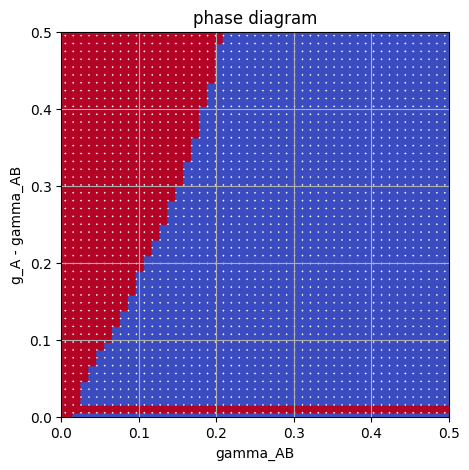

In [8]:
fig, ax = plt.subplots(figsize=(5, 5))
# ax.imshow(phase_diagram, cmap='hot', origin='lower')

x = xy_pairs[:,0]
y = xy_pairs[:,1]
ax.scatter(x,y, c=phase_diagram, cmap='coolwarm')

ax.set_xlabel('gamma_AB')
ax.set_ylabel('g_A - gamma_AB')
ax.set_title('phase diagram')
ax.set_xmargin(0)
ax.set_ymargin(0)
ax.grid(True)